In [1]:
import os
import sys
import numpy as np
import swyft
import pickle
import matplotlib.pyplot as plt
import torch
import importlib
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import LearningRateMonitor
torch.set_float32_matmul_precision('medium')
device_notebook = "cuda" if torch.cuda.is_available() else "cpu"
import wandb
import copy
from torch.multiprocessing import Pool
torch.multiprocessing.set_start_method('spawn',force=True)
torch.set_num_threads(28)
import itertools
import subprocess
from tqdm.auto import tqdm
sys.path.append('/home/gertwk/ALPs_with_SWYFT/analysis_scripts/ALP_sim')
from explim_functions import generate_expected_limits
import sympy as sy
from scipy.stats import norm, lognorm
from swyft.plot.mass import _get_jefferys_interval as interval
import random

In [2]:
main_dir = "ALPs_with_SWYFT"
thesis_figs = os.getcwd().split(main_dir)[0]+"/"+main_dir+"/thesis_figures/"

In [3]:
names = ['grid_informed_power5',]
gridpoints = [50,55]
colors_priors = ['r','#FFA500','y','g','b', ]

priors = {}
for ip, name in enumerate(names):

    priors[name] = {'name': name}

    priors[name]['results_path'] = '/home/gertwk/ALPs_with_SWYFT/cluster_runs/analysis_results/'+name

    priors[name]['store_path'] = priors[name]['results_path']+"/sim_output/store"

    priors[name]['config_vars'] = priors[name]['results_path'] +'/config_variables.pickle'

    priors[name]['config_phys'] = priors[name]['results_path'] +'/physics_variables.pickle'
    
    priors[name]['truncation_record'] = priors[name]['results_path'] +'/truncation_record.pickle'

    removed_ALP_sim=0
    try:
        sys.path.remove('/home/gertwk/ALPs_with_SWYFT/analysis_scripts/ALP_sim')
        removed_ALP_sim=1
    except ValueError:
        pass
    try:
        del sys.modules['ALP_quick_sim']
    except KeyError:
        pass
    sys.path.append(priors[name]['results_path'])
    import param_function
    import ALP_quick_sim
    with open(priors[name]['config_vars'], 'rb') as file: config_objects = pickle.load(file)
    for key in config_objects.keys(): priors[name][key] = config_objects[key]
    with open(priors[name]['config_phys'], 'rb') as file: config_objects = pickle.load(file)
    for key in config_objects.keys(): priors[name][key] = config_objects[key]
    with open(priors[name]['truncation_record'], 'rb') as file: config_objects = pickle.load(file)
    for key in config_objects.keys(): priors[name][key] = config_objects[key]
    sys.path.remove(priors[name]['results_path'])
    sys.path.append(priors[name]['results_path']+'/train_output/net')
    import network
    sys.path.remove(priors[name]['results_path']+'/train_output/net')
    
    

    priors[name]['net_path'] = {}
    priors[name]['net'] = {}
    for rnd in range(priors[name]['which_truncation']+1):
        round = 'round_'+str(rnd)
        priors[name]['net'][round] = {}
        priors[name]['net_path'][round] = {}
        for gp in gridpoints:
            gridpoint = 'grid_point_' + str(gp)
            priors[name]['net_path'][round][gridpoint] = (priors[name]['results_path'] + '/train_output/net/trained_network_'
                                                             +round+'_gridpoint_'+str(int(gp))+'.pt')

            count = 0
            for combo in itertools.product(*priors[name]['hyperparams'].values()):
                if count == gp:
                    hyperparams_point = {}
                    for i, key in enumerate(priors[name]['hyperparams'].keys()):
                        hyperparams_point[key]=combo[i]
                    break
                count +=1
          
            priors[name]['net'][round][gridpoint] = network.NetworkCorner(
                nbins=priors[name]['A'].nbins,
                marginals=priors[name]['POI_indices'],
                param_names=priors[name]['A'].param_names,
                **hyperparams_point,
            )
            priors[name]['net'][round][gridpoint].load_state_dict(torch.load(priors[name]['net_path'][round][gridpoint]))

    # with open(priors[name]['results_path']+'/explim_predictions.pickle', 'rb') as file:
    #     priors[name]['predictions'] = pickle.load(file)

    if priors[name]['which_truncation'] > 0:
        store = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name']+"_round_"+str(priors[name]['which_truncation'])+"_gridpoint_"+str(priors[name]['which_grid_point']))
        # store_explim = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name']+"_explim_round_"+str(priors[name]['which_truncation'])+"_gridpoint_"+str(priors[name]['which_grid_point']))
        store_prior = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name']+"_prior_round_"+str(priors[name]['which_truncation'])+"_gridpoint_"+str(priors[name]['which_grid_point']))
    else:
        store = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name'])
        # store_explim = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name']+"_explim")
        store_prior = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name']+"_prior")
    priors[name]['samples'] = store.get_sample_store()
    # priors[name]['samples_explim'] = store_explim.get_sample_store()
    priors[name]['samples_prior'] = store_prior.get_sample_store()
 
    del sys.modules['param_function']
    del sys.modules['ALP_quick_sim']
    del sys.modules['network']
    if removed_ALP_sim: sys.path.append('/home/gertwk/ALPs_with_SWYFT/analysis_scripts/ALP_sim')


/home/gertwk/.conda/envs/swyft4-dev-notebook/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [84]:
trainer = swyft.SwyftTrainer(accelerator = 'cuda', precision = 64,logger=False,enable_progress_bar=True)

In [5]:
sys.path

['/home/gertwk/ALPs_with_SWYFT/notebooks/thesis_results',
 '/home/gertwk/.conda/envs/swyft4-dev-notebook/lib/python39.zip',
 '/home/gertwk/.conda/envs/swyft4-dev-notebook/lib/python3.9',
 '/home/gertwk/.conda/envs/swyft4-dev-notebook/lib/python3.9/lib-dynload',
 '',
 '/home/gertwk/.conda/envs/swyft4-dev-notebook/lib/python3.9/site-packages',
 '/tmp/tmptww08p_f',
 '/home/gertwk/ALPs_with_SWYFT/analysis_scripts/ALP_sim']

In [6]:
def convert_pair_to_index(pair,n_indices):
    pair = sorted(pair)
    return int((pair[0]+1)*(n_indices-1+n_indices-pair[0]-1)/2 - n_indices + pair[1])

In [7]:
def weight(exp,n_bins):
    x = np.linspace(-1,1,n_bins)
    return 0.5+0.5*np.cos(np.pi*np.sign(x)*np.abs(x)**exp)

In [8]:
stdnorm = norm()

In [9]:
import time
class Timer():
    
    def __init__(self):
        self.start_time = None
        self.stop_time = None
    
    def start(self):
        self.start_time = time.time()
        
    def stop(self,what="Elapsed time"):
        self.stop_time = time.time()
        h,m,s = Timer.process_time(self.stop_time-self.start_time)
        print(what + ": "+str(h)+" h, "+str(m)+" min, "+str(s)+" sec.")
        self.start()

    def check(self,what="Elapsed time"):
        checked_time = time.time()
        if not self.start_time is None:
            time_increment = checked_time-self.start_time
        else:
            raise Error('There is no start time')
        h,m,s = Timer.process_time(time_increment)
        print(what + ": "+str(h)+" h, "+str(m)+" min, "+str(s)+" sec.")
    
    @staticmethod
    def process_time(s, round=False):
        h = int(s/3600)
        m = int((s-3600*h)/60)
        if round: 
            s = int(s-3600*h-60*m)
        else: 
            s = s-3600*h-60*m
        return h, m, s

T = Timer()

In [ ]:
class References():

    def __init__(
        self,
        samples_for_fit = None,
        x_freq = None,
        y_freq = None,
        x_exponent = None,
        y_exponent = None,
        x_phase = None,
        y_phase = None,
        min_freq = 1,
        max_freq = 1.4,
        min_freq_gap = 0.15,
        min_exponent = 0.8,
        max_exponent = 1.5,
        min_exponent_gap = 0.3,
        device = 'cpu',
    ):
        
        self.x_freq = x_freq
        self.y_freq = y_freq,
        self.x_exponent = x_exponent,
        self.y_exponent = y_exponent,
        self.x_phase = x_phase,
        self.y_phase = y_phase,
        self.min_freq = min_freq,
        self.max_freq = max_freq,
        self.min_freq_gap = min_freq_gap,
        self.min_exponent = min_exponent,
        self.max_exponent = max_exponent,
        self.min_exponent_gap = min_exponent_gap,

        self.fitted_parameters1 = None
        self.fitted_parameters2 = None
        self.phase_functions1 = None
        self.phase_functions2 = None
        if not samples_for_fit is None: self.fit_samples(samples_for_fit)


    def weight(exp,n_bins):
        x = np.linspace(-1,1,n_bins)
        return 0.5+0.5*np.cos(np.pi*np.sign(x)*np.abs(x)**exp)
    
    def standardized_sums(
        self,
        parsed_samples,
    ):
        try:
            samples = parsed_samples['data']
        except IndexError:
            samples = parsed_samples
     
        data_length = len(samples[0]) 
        start_of_range1 = np.random.randint(0,data_length)
        end_of_range1 = (start_of_range1 + int(data_length/2)) #np.random.randint( start_of_range1+int(data_length/3) , start_of_range1+int(2*data_length/3) )
        exp1 = np.random.uniform(0.5,2)
        exp2 = np.random.uniform(0.5,2)
        range1 = np.arange(start_of_range1,end_of_range1)%data_length
        range2 = np.arange(end_of_range1,end_of_range1+(start_of_range1-end_of_range1)%data_length)%data_length
    
        reordered_range1 = (np.concatenate([range1,range2])-int(data_length/2))%data_length
        reordered_range2 = (np.concatenate([range2,range1])-int(data_length/2))%data_length
        
        weights1 = self.weight(exp1,data_length)[reordered_range1]
        weights2 = self.weight(exp2,data_length)[reordered_range2]
    
        #>#
        samples1 = samples.copy()
        samples2 = samples.copy()
        #<#
    
        #>#
        bin_mins1 = np.min(samples1, axis=0)
        bin_maxes1 = np.max(samples1, axis=0)
        #<#
    
        #>#
        sums_of_standardized_bins1 = np.sum( weights1*((samples1-bin_mins1)/(bin_maxes1-bin_mins1)) ,axis=1)
        sums_of_standardized_bins1 = np.where(np.isinf(sums_of_standardized_bins1),0,sums_of_standardized_bins1)
        #<#
    
        max_sum1 = np.max(sums_of_standardized_bins1)
        min_sum1 = np.min(sums_of_standardized_bins1)
        standardized_sums1 = (sums_of_standardized_bins1-min_sum1)/(max_sum1-min_sum1)
    
        #>#
        bin_mins2 = np.min(samples2, axis=0)
        bin_maxes2 = np.max(samples2, axis=0)
        #<#
        
        #>#
        sums_of_standardized_bins2 = np.sum( weights2*((samples2-bin_mins2)/(bin_maxes2-bin_mins2)) ,axis=1)
        #<#
        
        sums_of_standardized_bins2 = np.where(np.isinf(sums_of_standardized_bins2),0,sums_of_standardized_bins2)
    
        max_sum2 = np.max(sums_of_standardized_bins2)
        min_sum2 = np.min(sums_of_standardized_bins2)
        standardized_sums2 = (sums_of_standardized_bins2-min_sum2)/(max_sum2-min_sum2)

        return standardized_sums1, standardized_sums2

    
    def fit_samples(
        self,
        standardized_sums1,
        standardized_sums2,
    ):

        fitted_parameters1 = lognorm.fit(standardized_sums1)
        fitted_parameters2 = lognorm.fit(standardized_sums2)
        
        phase_function1 = lognorm(fitted_parameters1[0], fitted_parameters1[1], fitted_parameters1[2]).cdf
        phase_function2 = lognorm(fitted_parameters2[0], fitted_parameters2[1], fitted_parameters2[2]).cdf
        
        self.fitted_parameters1 = fitted_parameters1
        self.fitted_parameters2 = fitted_parameters2

        self.phase_functions1 = phase_function1
        self.phase_functions2 = phase_function2
        

    def references2D(
        self,
        parsed_samples,
    ):
    
        standardized_sums1,standardized_sums2 = self.standardized_sums(parsed_samples)
    
        #>#
        sorted_sums1 = np.sort(standardized_sums1)
        sorted_sums2 = np.sort(standardized_sums2)
        #<#
    
        #>#
        try:
            phase_for_check1 = self.phase_function1(sorted_sums1)
            phase_for_check2 = self.phase_function2(sorted_sums2)
            phase1 = self.phase_function1(standardized_sums1)
            phase2 = self.phase_function2(standardized_sums2)
        except Error as Err:
            if self.phase_function1 is None or self.phase_function2 is None:
                self.fit_samples(standardized_sums1,standardized_sums1)
                phase_for_check1 = self.phase_function1(sorted_sums1)
                phase_for_check2 = self.phase_function2(sorted_sums2)
                phase1 = self.phase_function1(standardized_sums1)
                phase2 = self.phase_function2(standardized_sums2)
            else:
                raise Err 
        #<#

        x_freq = copy.copy(self.x_freq)
        y_freq = copy.copy(y_freq)
        x_exponent = copy.copy(x_exponent)
        y_exponent = copy.copy(y_exponent)
        x_phase = copy.copy(x_phase)
        y_phase = copy.copy(y_phase)
        min_freq = copy.copy(min_freq)
        max_freq = copy.copy(max_freq)
        min_freq_gap = copy.copy(min_freq_gap)
        min_exponent = copy.copy(min_exponent)
        max_exponent = copy.copy(max_exponent)
        min_exponent_gap = copy.copy(min_exponent_gap)

        #>#
        if x_phase is None: x_phase = np.random.uniform(0,1)
        if y_phase is None: y_phase = np.random.uniform(0,1)
    
        freq_range = max_freq-min_freq
        if x_freq is None: x_freq = np.random.uniform(min_freq,max_freq)
        if y_freq is None: y_freq = np.random.uniform(min(x_freq+min_freq_gap,max_freq)-min_freq, freq_range+max(x_freq-min_freq-min_freq_gap,0))%(freq_range) + min_freq
        
        if x_exponent is None: x_exponent = np.random.uniform(min_exponent,1) if x_freq > y_freq else np.random.uniform(1,max_exponent)
        if y_exponent is None: y_exponent = np.random.uniform(min_exponent,min(1,x_exponent-min_exponent_gap)) if x_freq < y_freq else np.random.uniform(max(1,x_exponent+min_exponent_gap),max_exponent)
    
        x_values_for_check = 0.5 + 0.5*np.sin(2*np.pi*(( x_freq*phase_for_check1)**x_exponent + x_phase ))
        y_values_for_check = 0.5 + 0.5*np.sin(2*np.pi*(( y_freq*phase_for_check2)**y_exponent + y_phase ))
        
        x_values = 0.5 + 0.5*np.sin(2*np.pi*(( x_freq*phase1)**x_exponent + x_phase ))
        y_values = 0.5 + 0.5*np.sin(2*np.pi*(( y_freq*phase2)**y_exponent + y_phase ))
        #<#
    
        random_variables = {
            'range1':range1,
            'range2':range2,
            'x_freq':x_freq,
            'y_freq':y_freq,
            'x_exponent':x_exponent,
            'y_exponent':y_exponent,
            'x_phase':x_phase,
            'y_phase':y_phase,
            'sums1':standardized_sums1,
            'sums2':standardized_sums2,
            'sorted_sums1':sorted_sums1,
            'sorted_sums2':sorted_sums2,
            'fitted_parameters1': fitted_parameters1,
            'fitted_parameters2': fitted_parameters2,
        }
        
        return np.array([x_values,y_values]).transpose(), np.array([x_values_for_check,y_values_for_check]).transpose(), random_variables
    

In [10]:
def references2D(
    parsed_samples,
    x_freq = None,
    y_freq = None,
    x_exponent = None,
    y_exponent = None,
    x_phase = None,
    y_phase = None,
    min_freq = 1,
    max_freq = 1.4,
    min_freq_gap = 0.15,
    min_exponent = 0.8,
    max_exponent = 1.5,
    min_exponent_gap = 0.3,
    device = 'cpu'
):

    try:
        samples = parsed_samples['data']
    except IndexError:
        samples = parsed_samples
 
    data_length = len(samples[0]) 
    start_of_range1 = np.random.randint(0,data_length)
    end_of_range1 = (start_of_range1 + int(data_length/2)) #np.random.randint( start_of_range1+int(data_length/3) , start_of_range1+int(2*data_length/3) )
    exp1 = np.random.uniform(0.5,2)
    exp2 = np.random.uniform(0.5,2)
    range1 = np.arange(start_of_range1,end_of_range1)%data_length
    range2 = np.arange(end_of_range1,end_of_range1+(start_of_range1-end_of_range1)%data_length)%data_length

    reordered_range1 = (np.concatenate([range1,range2])-int(data_length/2))%data_length
    reordered_range2 = (np.concatenate([range2,range1])-int(data_length/2))%data_length
    
    weights1 = weight(exp1,data_length)[reordered_range1]
    weights2 = weight(exp2,data_length)[reordered_range2]

    #>#
    samples1 = samples.copy()
    samples2 = samples.copy()
    #<#

    #>#
    bin_mins1 = np.min(samples1, axis=0)
    bin_maxes1 = np.max(samples1, axis=0)
    #<#

    #>#
    sums_of_standardized_bins1 = np.sum( weights1*((samples1-bin_mins1)/(bin_maxes1-bin_mins1)) ,axis=1)
    sums_of_standardized_bins1 = np.where(np.isinf(sums_of_standardized_bins1),0,sums_of_standardized_bins1)
    #<#

    max_sum1 = np.max(sums_of_standardized_bins1)
    min_sum1 = np.min(sums_of_standardized_bins1)
    standardized_sums1 = (sums_of_standardized_bins1-min_sum1)/(max_sum1-min_sum1)

    #>#
    bin_mins2 = np.min(samples2, axis=0)
    bin_maxes2 = np.max(samples2, axis=0)
    #<#
    
    #>#
    sums_of_standardized_bins2 = np.sum( weights2*((samples2-bin_mins2)/(bin_maxes2-bin_mins2)) ,axis=1)
    #<#
    
    sums_of_standardized_bins2 = np.where(np.isinf(sums_of_standardized_bins2),0,sums_of_standardized_bins2)

    max_sum2 = np.max(sums_of_standardized_bins2)
    min_sum2 = np.min(sums_of_standardized_bins2)
    standardized_sums2 = (sums_of_standardized_bins2-min_sum2)/(max_sum2-min_sum2)

    #>#
    sorted_sums1 = np.sort(standardized_sums1)
    sorted_sums2 = np.sort(standardized_sums2)
    #<#

    n_random_indices = min(len(standardized_sums1),1000)
    random_indices = random.sample(list(np.arange(len(standardized_sums1))), n_random_indices)
    fitted_parameters1 = lognorm.fit(standardized_sums1[random_indices])
    fitted_parameters2 = lognorm.fit(standardized_sums2[random_indices])
    
    phase_function1 = lognorm(fitted_parameters1[0], fitted_parameters1[1], fitted_parameters1[2]).cdf
    phase_function2 = lognorm(fitted_parameters2[0], fitted_parameters2[1], fitted_parameters2[2]).cdf

    #>#
    phase_for_check1 = phase_function1(sorted_sums1)
    phase_for_check2 = phase_function2(sorted_sums2)
    phase1 = phase_function1(standardized_sums1)
    phase2 = phase_function2(standardized_sums2)
    #<#

    #>#
    if x_phase is None: x_phase = np.random.uniform(0,1)
    if y_phase is None: y_phase = np.random.uniform(0,1)

    freq_range = max_freq-min_freq
    if x_freq is None: x_freq = np.random.uniform(min_freq,max_freq)
    if y_freq is None: y_freq = np.random.uniform(min(x_freq+min_freq_gap,max_freq)-min_freq, freq_range+max(x_freq-min_freq-min_freq_gap,0))%(freq_range) + min_freq
    
    if x_exponent is None: x_exponent = np.random.uniform(min_exponent,1) if x_freq > y_freq else np.random.uniform(1,max_exponent)
    if y_exponent is None: y_exponent = np.random.uniform(min_exponent,min(1,x_exponent-min_exponent_gap)) if x_freq < y_freq else np.random.uniform(max(1,x_exponent+min_exponent_gap),max_exponent)

    x_values_for_check = 0.5 + 0.5*np.sin(2*np.pi*(( x_freq*phase_for_check1)**x_exponent + x_phase ))
    y_values_for_check = 0.5 + 0.5*np.sin(2*np.pi*(( y_freq*phase_for_check2)**y_exponent + y_phase ))
    
    x_values = 0.5 + 0.5*np.sin(2*np.pi*(( x_freq*phase1)**x_exponent + x_phase ))
    y_values = 0.5 + 0.5*np.sin(2*np.pi*(( y_freq*phase2)**y_exponent + y_phase ))
    #<#

    
    random_variables = {
        'range1':range1,
        'range2':range2,
        'x_freq':x_freq,
        'y_freq':y_freq,
        'x_exponent':x_exponent,
        'y_exponent':y_exponent,
        'x_phase':x_phase,
        'y_phase':y_phase,
        'sums1':standardized_sums1,
        'sums2':standardized_sums2,
        'sorted_sums1':sorted_sums1,
        'sorted_sums2':sorted_sums2,
        'fitted_parameters1': fitted_parameters1,
        'fitted_parameters2': fitted_parameters2,
    }
    
    return np.array([x_values,y_values]).transpose(), np.array([x_values_for_check,y_values_for_check]).transpose(), random_variables

In [12]:
len(priors[name]['samples_prior'])

400000

In [49]:
try:
    del sys.modules['DRP_test']
except KeyError:
    pass
try:
    del sys.modules['reference_functions']
except KeyError:
    pass
from DRP_test import get_drp_coverage, get_drp_coverage_torch, draw_DRP_samples_fast
from reference_functions import References
R = References()
references2D = R.references2D

In [54]:
%%time
references_2d = [
                references2D(priors[name]['samples'][-1000:])[0] for _ in range(1)
            ]

CPU times: user 7.44 ms, sys: 6.93 ms, total: 14.4 ms
Wall time: 13.3 ms


In [87]:
%%time

def test_DRP_values(tries=3,n_samps=1000, n_prior_samps=1000, n_refs=100, gridpoints=gridpoints, batch_size=1024):
    name = names[0]
    which_truncation = priors[name]['which_truncation']
    which_grid_point = priors[name]['which_grid_point']
    POIs = priors[name]['POI_indices']
    A = priors[name]['A']
    bounds = np.array(priors[name]['bounds_rounds'][which_grid_point][which_truncation])
    
    try:
        random_indices = random.sample(list(np.arange(n_samps*tries)), n_samps*tries)
    except ValueError:
        random_indices = list(np.concatenate([random.sample(list(np.arange(n_samps)), n_samps) for trial in range(tries)]))
    try:
        random_prior_indices = random.sample(list(np.arange(n_prior_samps*tries)), n_prior_samps*tries)
    except ValueError:
        random_prior_indices = list(np.concatenate([random.sample(list(np.arange(n_prior_samps)), n_prior_samps) for trial in range(tries)]))
        
    round = 'round_0'
    validation_sums = {}
    for gp in gridpoints:
        print()
        gridpoint = "grid_point_"+str(gp)
        print('Gridpoint ' + str(gp))
        validation_sums[gp] = np.zeros(tries)
        print('Computing references...', flush=True, end="")
        references_2d = [
            references2D(priors[name]['samples'])[0] for _ in range(tries)
        ]
        print(' done.')
        for trial in range(tries):
            print('Computing trial '+str(trial), flush=True, end='\r')
            samples = swyft.Samples({key:val[random_indices[trial*n_samps:(trial+1)*n_samps]] for key,val in priors[name]['samples'].items()})
            prior_samples = swyft.Samples({key:val[random_prior_indices[trial*n_prior_samps:(trial+1)*n_prior_samps]] for key,val in priors[name]['samples_prior'].items()})

            draws1d,draws2d,weights1d,weights2d = draw_DRP_samples_fast(
                priors[name]['net'][round][gridpoint],
                trainer,
                samples,
                prior_samples,
                batch_size=batch_size,
            )

            key = list(draws2d.keys())[0]
            
            rows = len(POIs)

            validation_sum = 0
 
            ecp_pp, alpha_pp, _, _, _,_,f_score,_ = get_drp_coverage_torch(
                draws2d[key],
                samples['params'][:,[0,1]],
                weights = weights2d[key],
                theta_names=np.array(A.param_names)[[0,1]],
                bounds = np.array(bounds)[[0,1]],
                references = references_2d[trial][random_indices[trial*n_samps:(trial+1)*n_samps]],
                device='cuda'
            )
            
            validation_sum += f_score
            
            validation_sums[gp][trial] = validation_sum
            
            # print(validation_sum)
        print()
        
    return validation_sums
        
        

CPU times: user 12 µs, sys: 0 ns, total: 12 µs
Wall time: 16.9 µs


In [74]:
def test_theoretical_f_stability(mock_bins=50,mock_n_per_bin=10, mock_n_ref=10_000, mock_tries=1):
    mock_n = mock_bins*mock_n_per_bin 
    mock_alpha = np.linspace(0,1,mock_bins+1)[1:]
    mock_dx = mock_alpha[1]-mock_alpha[0]
    mock_upper = 1+3*mock_n_per_bin**(-0.5)
    mock_lower = 1-3*mock_n_per_bin**(-0.5)
    mock_uncertainty = (mock_upper-mock_lower)/2
    mock_validation_sums = np.zeros((mock_tries,))
    for trial in range(mock_tries):
        # print('Computing trial '+str(trial), flush=True, end='\r')
        mock_validation_sum = 0
        for ref_i in range(mock_n_ref):
            mock_f = np.random.uniform(size=(mock_n,))
            mock_histogram = torch.histogram(torch.tensor(mock_f), density=True, bins=mock_bins ,range=(0,1))
            mock_h = np.array(mock_histogram.hist)
            mock_validation_sum += np.sum(((mock_h-1)/mock_uncertainty)**2)/(mock_n_ref*mock_bins)
        mock_validation_sums[trial] = mock_validation_sum
    print()
    _, alpha,_ = plt.hist(mock_validation_sums, density=True, alpha=0.5)

    # print(mock_n)
    # print(mock_alpha)
    # print(mock_n_per_bin)
    # print(mock_uncertainty)
    return [alpha[0],alpha[-1]]


CPU times: user 4min 30s, sys: 130 ms, total: 4min 30s
Wall time: 9.72 s


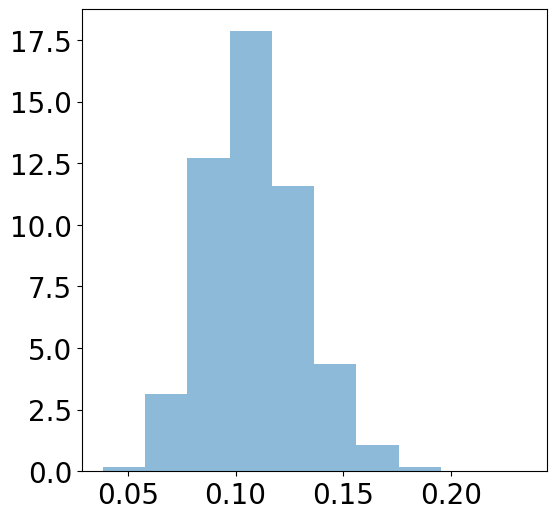

In [75]:
%%time
fig = plt.figure(figsize=(6,6))
fig.add_subplot(1,1,1)
ran = test_theoretical_f_stability(mock_bins=50, mock_n_ref=1, mock_tries=100_000, mock_n_per_bin=20)

In [95]:
trainer = swyft.SwyftTrainer(accelerator = 'cuda', precision = 64,logger=False,enable_progress_bar=False)

In [90]:
%%time
sums1 = test_DRP_values(tries = 25, n_samps=1000, n_refs=1, n_prior_samps=10_00, gridpoints=[50], batch_size=1024)


Gridpoint 50
Computing references... done.


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]


CPU times: user 5min 25s, sys: 12 s, total: 5min 37s
Wall time: 5min 29s


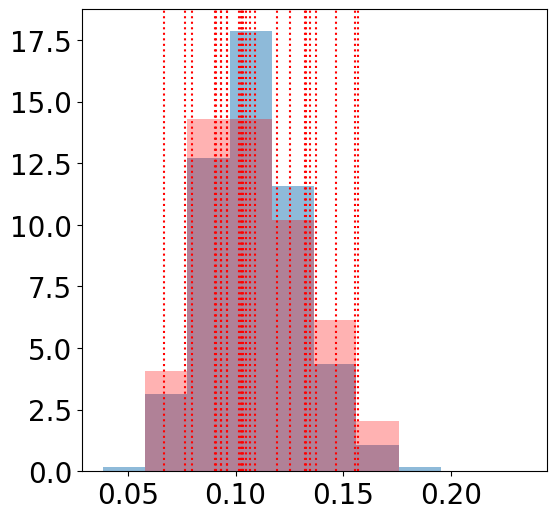

In [91]:
sums = sums1
new_fig = copy.deepcopy(fig)
for gp, gridpoint in enumerate([50]):
    color = ['r','g'][gp]
    for s in sums[gridpoint]:
        new_fig.axes[0].axvline(s, color=color, linestyle=':')
    new_fig.axes[0].hist(sums[gridpoint], color=color, alpha = 0.3, density = True, range=ran)
new_fig

In [96]:
%%time
sums2 = test_DRP_values(tries = 150, n_samps=1000, n_refs=1, n_prior_samps=10_00, gridpoints=[50], batch_size=1024)


Gridpoint 50
Computing references... done.
Computing trial 149
CPU times: user 30min 38s, sys: 54.8 s, total: 31min 33s
Wall time: 31min 17s


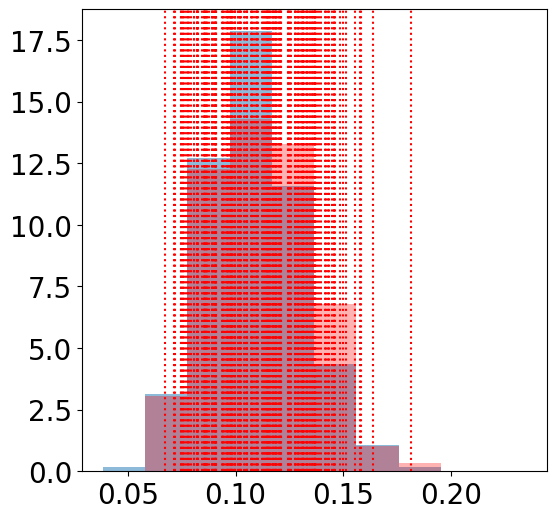

In [97]:
sums = sums2
new_fig = copy.deepcopy(fig)
for gp, gridpoint in enumerate([50]):
    color = ['r','g'][gp]
    for s in sums[gridpoint]:
        new_fig.axes[0].axvline(s, color=color, linestyle=':')
    new_fig.axes[0].hist(sums[gridpoint], color=color, alpha = 0.3, density = True, range=ran)
new_fig

In [98]:
%%time
sums3 = test_DRP_values(tries = 150, n_samps=1000, n_refs=1, n_prior_samps=10_00, gridpoints=[55], batch_size=1024)


Gridpoint 55
Computing references... done.
Computing trial 149
CPU times: user 30min 57s, sys: 54.6 s, total: 31min 51s
Wall time: 31min 35s


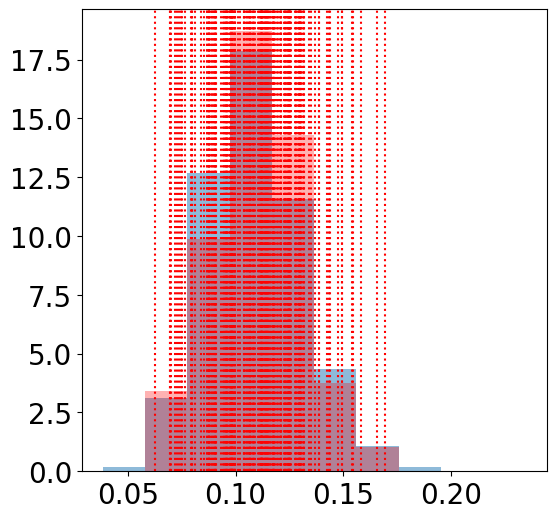

In [100]:
sums = sums3
new_fig = copy.deepcopy(fig)
for gp, gridpoint in enumerate([55]):
    color = ['r','g'][gp]
    for s in sums[gridpoint]:
        new_fig.axes[0].axvline(s, color=color, linestyle=':')
    new_fig.axes[0].hist(sums[gridpoint], color=color, alpha = 0.3, density = True, range=ran)
new_fig

In [23]:
%%time
sums4 = test_DRP_values(tries = 5, n_samps=1000, n_refs=100, n_prior_samps=400_00)


Gridpoint 50


Predicting: 0it [00:00, ?it/s]

Computing references... done.
0.11141111111111104



Predicting: 0it [00:00, ?it/s]

Computing references... done.
0.11143999999999997



Predicting: 0it [00:00, ?it/s]

Computing references... done.
0.10726444444444445



Predicting: 0it [00:00, ?it/s]

Computing references... done.
0.1096488888888888



Predicting: 0it [00:00, ?it/s]

Computing references... done.
0.1110777777777778


Gridpoint 55


Predicting: 0it [00:00, ?it/s]

Computing references... done.
0.11224888888888901



Predicting: 0it [00:00, ?it/s]

Computing references... done.
0.10986000000000001



Predicting: 0it [00:00, ?it/s]

Computing references... done.
0.1074911111111111



Predicting: 0it [00:00, ?it/s]

Computing references... done.
0.11280444444444442



Predicting: 0it [00:00, ?it/s]

Computing references... done.
0.11024222222222217

CPU times: user 1h 31min 28s, sys: 7min 56s, total: 1h 39min 25s
Wall time: 1h 35min 54s


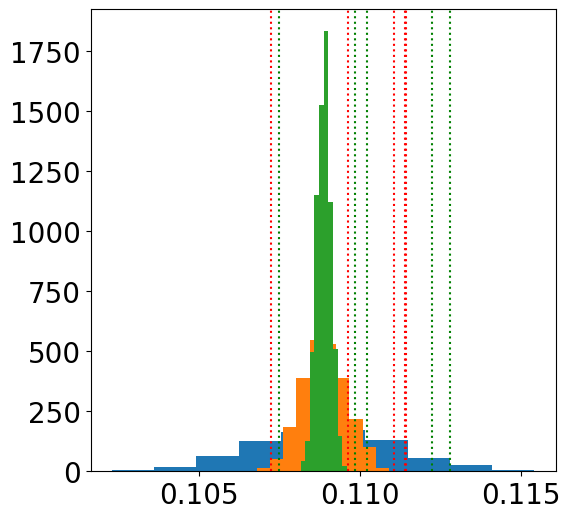

In [24]:
sums = sums4
new_fig = copy.deepcopy(fig)
for gp, gridpoint in enumerate(gridpoints):
    color = ['r','g'][gp]
    for s in sums[gridpoint]:
        new_fig.axes[0].axvline(s, color=color, linestyle=':')
new_fig

In [25]:
%%time
sums5 = test_DRP_values(tries = 5, n_samps=1000, n_refs=1_000, n_prior_samps=400_00)


Gridpoint 50


Predicting: 0it [00:00, ?it/s]

Computing references... done.
0.1096808888888889



Predicting: 0it [00:00, ?it/s]

Computing references... done.
0.1079722222222222



Predicting: 0it [00:00, ?it/s]

Computing references... done.
0.11275733333333336



Predicting: 0it [00:00, ?it/s]

Computing references... done.
0.10809866666666668



Predicting: 0it [00:00, ?it/s]

Computing references... done.
0.1089659999999999


Gridpoint 55


Predicting: 0it [00:00, ?it/s]

Computing references... done.
0.10689177777777768



Predicting: 0it [00:00, ?it/s]

Computing references... done.
0.10691466666666664



Predicting: 0it [00:00, ?it/s]

Computing references... done.
0.11284555555555563



Predicting: 0it [00:00, ?it/s]

Computing references... done.
0.10814644444444435



Predicting: 0it [00:00, ?it/s]

Computing references... done.
0.10668555555555573

CPU times: user 3h 19min 2s, sys: 5min 59s, total: 3h 25min 2s
Wall time: 2h 57min 8s


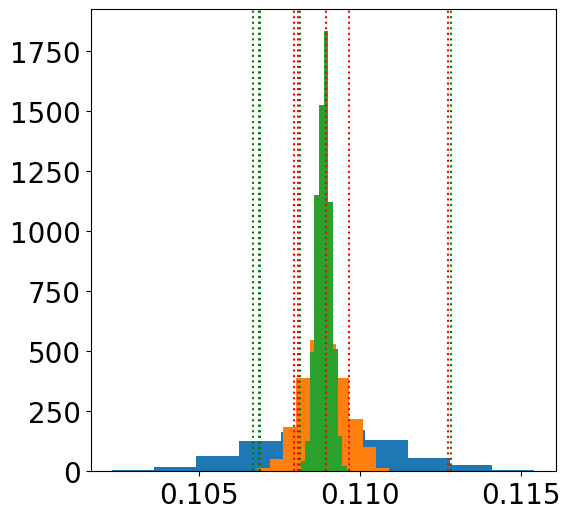

In [26]:
sums = sums5
new_fig = copy.deepcopy(fig)
for gp, gridpoint in enumerate(gridpoints):
    color = ['r','g'][gp]
    for s in sums[gridpoint]:
        new_fig.axes[0].axvline(s, color=color, linestyle=':')
new_fig

In [27]:
%%time
sums6 = test_DRP_values(tries = 5, n_samps=1000, n_refs=10_000, n_prior_samps=400_00)


Gridpoint 50


Predicting: 0it [00:00, ?it/s]

Computing references... done.
0.10674479999999995



Predicting: 0it [00:00, ?it/s]

Computing references... done.
0.10749502222222213



Predicting: 0it [00:00, ?it/s]

Computing references... done.
0.10864291111111109



Predicting: 0it [00:00, ?it/s]

Computing references... done.
0.10834517777777748



Predicting: 0it [00:00, ?it/s]

Computing references... done.
0.10951311111111096


Gridpoint 55


Predicting: 0it [00:00, ?it/s]

Computing references... done.
0.10680597777777787



Predicting: 0it [00:00, ?it/s]

Computing references... done.
0.10784042222222145



Predicting: 0it [00:00, ?it/s]

Computing references... done.
0.1074108222222225



Predicting: 0it [00:00, ?it/s]

Computing references... done.
0.10776402222222183



Predicting: 0it [00:00, ?it/s]

Computing references... done.
0.11006037777777805

CPU times: user 11h 44min 13s, sys: 5min 19s, total: 11h 49min 33s
Wall time: 7h 16min 42s


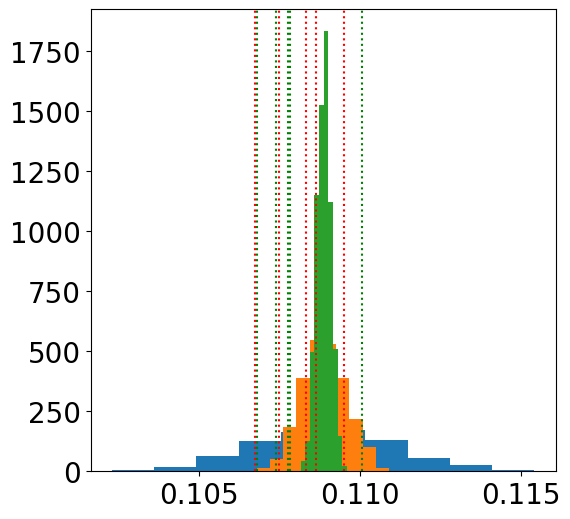

In [28]:
sums = sums6
new_fig = copy.deepcopy(fig)
for gp, gridpoint in enumerate(gridpoints):
    color = ['r','g'][gp]
    for s in sums[gridpoint]:
        new_fig.axes[0].axvline(s, color=color, linestyle=':')
new_fig